Loading shapefile: SWOT_L2_HR_RiverSP_Reach_033_400_EU_20250602T034813_20250602T040036_PID0_01.shp
Loaded 1354 features.
Longitude range: 22.633210 - 50.773101
Latitude  range: 30.047937 - 70.435457
Found 9 unique reach identifiers in the bbox.
Plotting reaches colored by WSE...


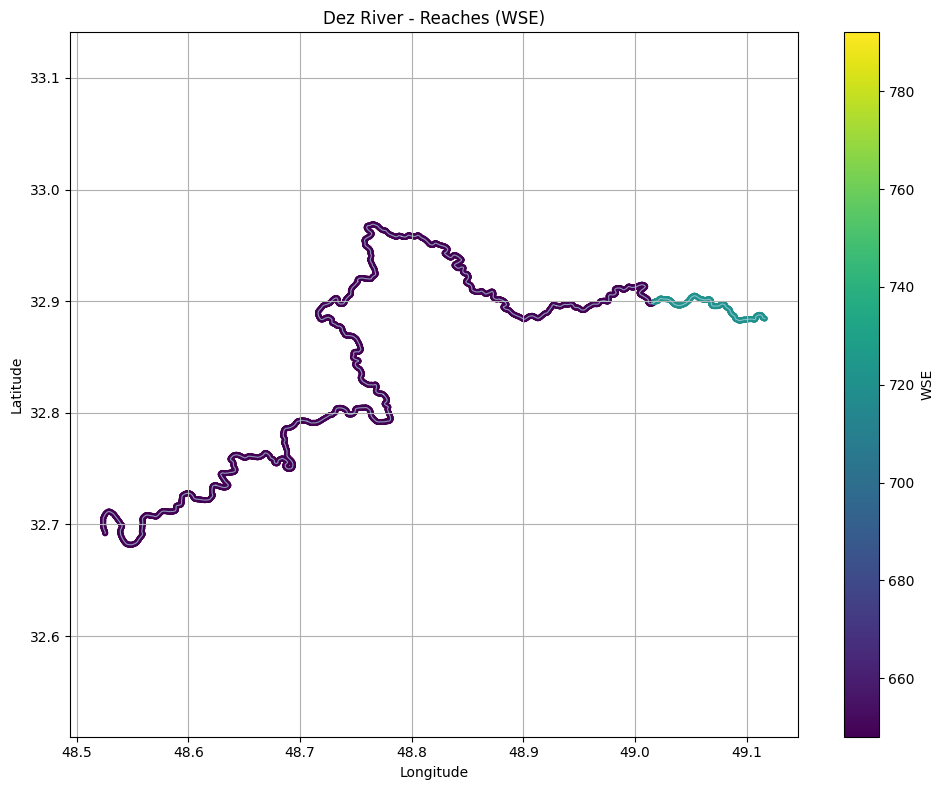

Plotting full river outline...


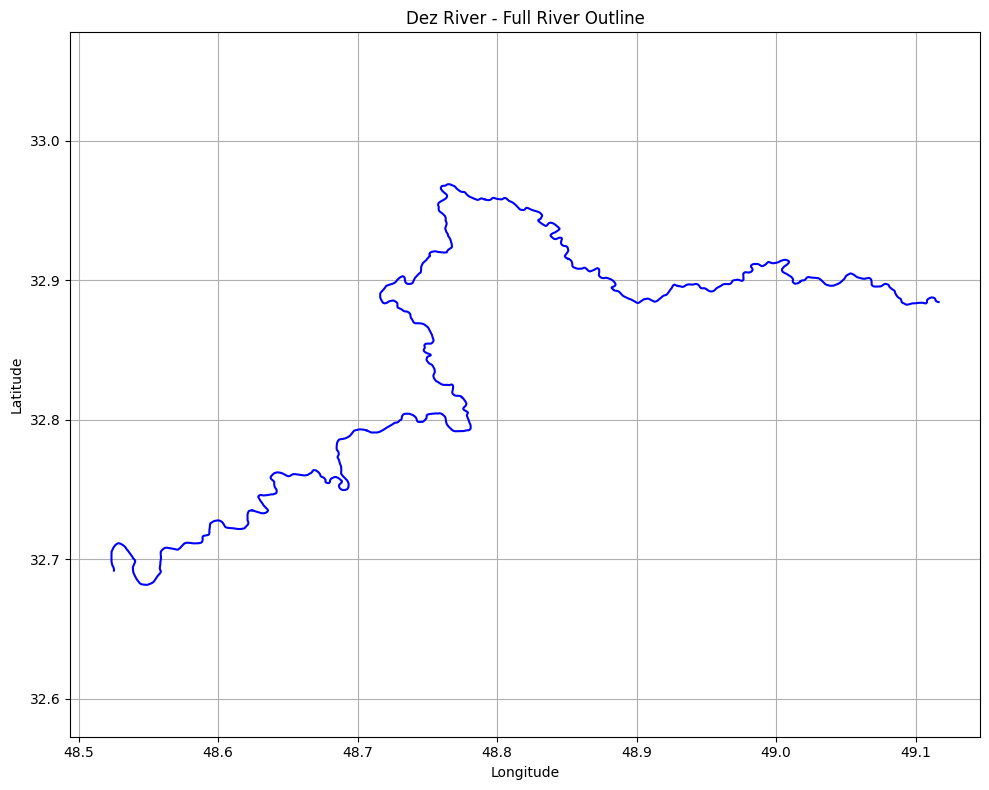


--- Reach summary ---
Reach 29420400243: 589 vertices, WSE samples: [-1.e+12]
Reach 29420400251: 581 vertices, WSE samples: [-1.e+12]
Reach 29420400261: 371 vertices, WSE samples: [402.073]
Reach 29420400271: 569 vertices, WSE samples: [476.185]
Reach 29420400281: 329 vertices, WSE samples: [537.6929]
Reach 29420400291: 318 vertices, WSE samples: [582.2613]
Reach 29420400301: 318 vertices, WSE samples: [625.8678]
Reach 29420400311: 372 vertices, WSE samples: [673.9714]
Reach 29420400321: 368 vertices, WSE samples: [720.0531]
Analysis complete.


In [5]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Dez River SWOT Reach Analysis (refactored)
============================================
Robust reader + bbox filter + WSE extraction + plotting.

Author: Shayan Shirafkan (adapted)
Date: 2025-11-04
License: MIT

Requires:
    geopandas, shapely, numpy, matplotlib
Optional (for satellite basemap):
    contextily
"""
from __future__ import annotations
import os
import sys
import argparse
from typing import List, Tuple

import numpy as np
import geopandas as gpd
from shapely.geometry import Point, LineString, MultiLineString
import matplotlib.pyplot as plt

# ------------------------------------------------------------
# Utility functions
# ------------------------------------------------------------
def ensure_shapefile_components(shp_path: str) -> bool:
    """Check that .shp, .shx, .dbf exist in the same folder with same basename."""
    base = os.path.splitext(shp_path)[0]
    required = [base + ext for ext in (".shp", ".shx", ".dbf")]
    missing = [p for p in required if not os.path.exists(p)]
    if missing:
        print("Warning: missing shapefile components:", ", ".join(missing))
        return False
    return True

def extract_coords_from_geom(geom) -> Tuple[List[float], List[float]]:
    """
    Return lists (xs, ys) for any Point/LineString/MultiLineString geometry.
    Returns empty lists for unsupported/empty geometries.
    """
    if geom is None:
        return [], []
    geom_type = geom.geom_type
    if geom_type == "Point":
        return [geom.x], [geom.y]
    if geom_type == "LineString":
        xs, ys = geom.xy
        return list(xs), list(ys)
    if geom_type == "MultiLineString":
        xs_all, ys_all = [], []
        for part in geom.geoms:
            xs, ys = part.xy
            xs_all.extend(xs)
            ys_all.extend(ys)
        return xs_all, ys_all
    # Fallback: try to get coordinates if shapely supports it
    try:
        coords = list(geom.coords)
        if coords:
            xs, ys = zip(*coords)
            return list(xs), list(ys)
    except Exception:
        pass
    return [], []

def any_point_in_bbox(xs: List[float], ys: List[float],
                      lon_min: float, lon_max: float,
                      lat_min: float, lat_max: float) -> bool:
    if len(xs) == 0:
        return False
    arr_x = np.array(xs)
    arr_y = np.array(ys)
    mask = (arr_x >= lon_min) & (arr_x <= lon_max) & (arr_y >= lat_min) & (arr_y <= lat_max)
    return np.any(mask)

def repeat_value_for_vertices(value, n_vertices: int):
    """If value is scalar, repeat it to match vertex count. If it's iterable, try to match length."""
    if n_vertices <= 0:
        return np.array([])
    if value is None:
        return np.full(n_vertices, np.nan)
    try:
        # If value is a scalar (not iterable or string), this will fail the iteration check below
        iter(value)
        # But guard against strings which are iterable
        if isinstance(value, (str, bytes)):
            raise TypeError
        arr = np.asarray(value)
        if arr.size == n_vertices:
            return arr
        if arr.size == 1:
            return np.full(n_vertices, arr.item())
        # otherwise, if different length, broadcast or truncate
        repeated = np.resize(arr, n_vertices)
        return repeated
    except TypeError:
        # scalar
        return np.full(n_vertices, value)

# ------------------------------------------------------------
# Main processing
# ------------------------------------------------------------
def main(args):
    shp = args.shapefile
    lat_min, lat_max = args.lat_min, args.lat_max
    lon_min, lon_max = args.lon_min, args.lon_max

    # Try to allow GDAL to restore .shx if missing
    os.environ.setdefault("SHAPE_RESTORE_SHX", "YES")

    # Inform about missing components (but still attempt read)
    ensure_shapefile_components(shp)

    print(f"Loading shapefile: {shp}")
    try:
        gdf = gpd.read_file(shp)
    except Exception as e:
        print("Error reading shapefile:", e)
        print("If the error mentions missing .shx, ensure GDAL is installed and SHAPE_RESTORE_SHX is set to YES.")
        sys.exit(1)

    if gdf.empty:
        print("Loaded GeoDataFrame is empty. Exiting.")
        sys.exit(1)

    print(f"Loaded {len(gdf)} features.")

    # Collect global coordinate ranges safely
    all_xs, all_ys = [], []
    for geom in gdf.geometry:
        xs, ys = extract_coords_from_geom(geom)
        all_xs.extend(xs)
        all_ys.extend(ys)

    if len(all_xs) == 0 or len(all_ys) == 0:
        print("No coordinate vertices found in geometries. Exiting.")
        sys.exit(1)

    all_xs = np.array(all_xs)
    all_ys = np.array(all_ys)
    print(f"Longitude range: {all_xs.min():.6f} - {all_xs.max():.6f}")
    print(f"Latitude  range: {all_ys.min():.6f} - {all_ys.max():.6f}")

    # Filter features whose any vertex lies inside bbox
    in_bbox_mask = []
    for geom in gdf.geometry:
        xs, ys = extract_coords_from_geom(geom)
        in_bbox_mask.append(any_point_in_bbox(xs, ys, lon_min, lon_max, lat_min, lat_max))
    gdf["in_zohreh"] = in_bbox_mask

    subset = gdf[gdf["in_zohreh"]].copy()
    if subset.empty:
        print("No reaches found inside the specified bounding box. Exiting.")
        sys.exit(0)

    # Try to find a column named 'reach_id' (case-insensitive) and 'wse' for WSE values
    cols_lower = {c.lower(): c for c in subset.columns}
    reach_col = cols_lower.get("reach_id") or cols_lower.get("reachid") or None
    wse_col = cols_lower.get("wse") or cols_lower.get("water_surface_elevation") or None

    if reach_col is None:
        print("Warning: no 'reach_id' column found. Using feature index as reach identifier.")
        subset["_reach_id_idx"] = np.arange(len(subset))
        reach_col = "_reach_id_idx"

    if wse_col is None:
        print("Warning: no 'wse' column found. WSE will be assumed NaN.")
        subset["_wse_na"] = np.nan
        wse_col = "_wse_na"

    # Ensure reach ids are numeric if possible
    try:
        subset["_reach_id_numeric"] = subset[reach_col].astype(float)
    except Exception:
        subset["_reach_id_numeric"] = subset[reach_col].apply(lambda v: hash(str(v)))  # fallback

    unique_reaches = subset["_reach_id_numeric"].unique()
    print(f"Found {len(unique_reaches)} unique reach identifiers in the bbox.")

    # Build reach_data list
    reach_data = []
    for rid in unique_reaches:
        part = subset[subset["_reach_id_numeric"] == rid]
        xs_all, ys_all, wse_all = [], [], []

        for geom, wse in zip(part.geometry, part[wse_col]):
            xs, ys = extract_coords_from_geom(geom)
            n_vert = len(xs)
            if n_vert == 0:
                continue
            xs_all.extend(xs)
            ys_all.extend(ys)
            wse_arr = repeat_value_for_vertices(wse, n_vert)
            wse_all.extend(wse_arr.tolist())

        if len(xs_all) == 0:
            continue

        xs_np = np.array(xs_all, dtype=float)
        ys_np = np.array(ys_all, dtype=float)
        wse_np = np.array(wse_all, dtype=float)

        reach_data.append({
            "reach_id": float(rid),
            "X": xs_np,
            "Y": ys_np,
            "WSE": wse_np
        })

    if not reach_data:
        print("No valid reach vertices assembled. Exiting.")
        sys.exit(0)

    # ---- Plotting helpers ----
    def plot_reaches(reaches, title: str, color_by_wse: bool = True):
        plt.figure(figsize=(10, 8))
        ax = plt.gca()
        for r in reaches:
            X, Y, W = r["X"], r["Y"], r["WSE"]
            valid_mask = np.isfinite(X) & np.isfinite(Y)
            if color_by_wse:
                color_mask = valid_mask & np.isfinite(W)
                if np.any(color_mask):
                    sc = ax.scatter(X[color_mask], Y[color_mask], c=W[color_mask],
                                    cmap="viridis", s=18, edgecolors="none")
                # plot line outline too
                ax.plot(X[valid_mask], Y[valid_mask], color="lightblue", linewidth=0.8, alpha=0.7)
            else:
                ax.plot(X[valid_mask], Y[valid_mask], color="blue", linewidth=1.5)
        ax.set_aspect("equal", adjustable="datalim")
        ax.set_xlabel("Longitude")
        ax.set_ylabel("Latitude")
        ax.set_title(title)
        ax.grid(True)
        if color_by_wse:
            # create colorbar from last scatter if exists
            try:
                plt.colorbar(sc, ax=ax, label="WSE")
            except Exception:
                pass
        plt.tight_layout()
        plt.show()

    # Plot WSE by reach
    print("Plotting reaches colored by WSE...")
    plot_reaches(reach_data, "Dez River - Reaches (WSE)", color_by_wse=True)

    # Plot full outline
    print("Plotting full river outline...")
    plot_reaches(reach_data, "Dez River - Full River Outline", color_by_wse=False)

    # Summary printout
    print("\n--- Reach summary ---")
    for r in reach_data:
        vals = r["WSE"][np.isfinite(r["WSE"])]
        unique_vals = np.unique(np.round(vals, 4)) if vals.size else np.array([])
        print(f"Reach {int(r['reach_id']) if r['reach_id'].is_integer() else r['reach_id']}: "
              f"{len(r['X'])} vertices, WSE samples: {unique_vals if unique_vals.size else 'None'}")

    # Optional satellite basemap
    if args.satellite:
        try:
            import contextily as ctx
            from shapely.geometry import LineString
            print("Plotting on satellite basemap (contextily)...")
            # Build GeoDataFrame of lines and reproject to web mercator
            lines = []
            for r in reach_data:
                coords = np.column_stack((r["X"], r["Y"]))
                # create a LineString; if only one point, create small line to avoid errors
                if coords.shape[0] == 1:
                    coords = np.vstack([coords, coords + 1e-6])
                lines.append(LineString(coords))
            gdf_plot = gpd.GeoDataFrame(geometry=lines, crs="EPSG:4326").to_crs(epsg=3857)

            fig, ax = plt.subplots(figsize=(10, 8))
            gdf_plot.plot(ax=ax, linewidth=2, facecolor="none", edgecolor="blue")
            ctx.add_basemap(ax, source=ctx.providers.Esri.WorldImagery)
            ax.set_title("Dez River - SWOT Reaches on Satellite Map")
            plt.tight_layout()
            plt.show()
        except Exception as e:
            print("Could not plot satellite basemap (missing contextily or error):", e)

    print("Analysis complete.")

# ------------------------------------------------------------
# CLI
# ------------------------------------------------------------
if __name__ == "__main__":
    parser = argparse.ArgumentParser(description="Dez River SWOT Reach Analysis")
    parser.add_argument("shapefile", nargs="?",
                        default="SWOT_L2_HR_RiverSP_Reach_033_400_EU_20250602T034813_20250602T040036_PID0_01.shp",
                        help="Path to .shp file")
    parser.add_argument("--lat-min", type=float, default=32.678, help="Latitude minimum for bbox")
    parser.add_argument("--lat-max", type=float, default=32.970, help="Latitude maximum for bbox")
    parser.add_argument("--lon-min", type=float, default=48.521, help="Longitude minimum for bbox")
    parser.add_argument("--lon-max", type=float, default=49.121, help="Longitude maximum for bbox")
    parser.add_argument("--satellite", action="store_true", help="Plot satellite basemap (requires contextily)")
    args = parser.parse_args(args=[])
    main(args)
